In [60]:
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
# Dataset available at https://data.cityofnewyork.us/City-Government/Good-Food-Purchasing-Data/usrf-za7k
path = 'Good_Food_Purchasing_Data.csv'
df_0 = pd.read_csv(path)

In [3]:
df_0.shape

(17208, 12)

In [4]:
df_0.columns

Index(['Agency', 'Time Period', 'Food Product Group', 'Food Product Category',
       'Product Name', 'Product Type', 'Origin Detail', 'Distributor',
       'Vendor', '# of Units', 'Total Weight in lbs', 'Total Cost'],
      dtype='object')

In [5]:
df_0.head()

,Agency,Time Period,Food Product Group,Food Product Category,Product Name,Product Type,Origin Detail,Distributor,Vendor,# of Units,Total Weight in lbs,Total Cost
0,Administration for Childrens Services,2018-2019,Meals,Meals,"baby food, dinner, assorted","Stage 2 Baby Food Dinner, Assorted Variety",Beech-Nut,Babylab Inc.,Babylab Inc.,40.0,100.0,560.0
1,Administration for Childrens Services,2018-2019,Meals,Meals,"baby food, dinner, assorted","Stage 3 Baby Food Dinner, Assorted Variety",Beech-Nut,Babylab Inc.,Babylab Inc.,40.0,106.0,600.0
2,Administration for Childrens Services,2018-2019,Meals,Meals,"baby food, formula","Premium Nursette Ready-to-Feed Infant Formula,...",Enfamil,Babylab Inc.,Babylab Inc.,200.0,1200.0,16200.0
3,Administration for Childrens Services,2018-2019,Beverages,Beverages,"juice, fruit punch, ss","100% Juice Variety Pack, 4 fl oz bottles",Enfamil,Babylab Inc.,Babylab Inc.,100.0,600.0,1940.0
4,Administration for Childrens Services,2018-2019,Condiments & Snacks,Condiments & Snacks,"cereal, baby, oatmeal",Single Grain Oatmeal Baby Cereal,Enfamil,Babylab Inc.,Babylab Inc.,10.0,60.0,290.0


In [6]:
df_0.dtypes

Agency                    object
Time Period               object
Food Product Group        object
Food Product Category     object
Product Name              object
Product Type              object
Origin Detail             object
Distributor               object
Vendor                    object
# of Units               float64
Total Weight in lbs      float64
Total Cost               float64
dtype: object

In [7]:
df_0.describe()

,# of Units,Total Weight in lbs,Total Cost
count,1.715200e+04,1.715000e+04,3.767000e+03
mean,1.915848e+04,2.886157e+04,1.398539e+05
std,5.987577e+05,3.260171e+05,4.243162e+05
min,-3.600000e+01,-2.330000e+02,0.000000e+00
25%,3.000000e+00,2.200000e+01,1.210000e+03
50%,1.700000e+01,1.470000e+02,1.570800e+04
75%,2.110000e+02,1.811500e+03,9.308300e+04
max,5.050947e+07,2.525474e+07,9.110741e+06


## Cleaning
From the cell above, I noticed a couple of things:
- min of `Total Weight in lbs` and `# of Units` is negative, which doesn't make sense.

In [8]:
df_0.isna().sum() # check for null values per column

Agency                       0
Time Period                  0
Food Product Group           0
Food Product Category        0
Product Name                 1
Product Type                 0
Origin Detail             2149
Distributor                911
Vendor                     486
# of Units                  56
Total Weight in lbs         58
Total Cost               13441
dtype: int64

#### Rows where the `Total Weight in lbs` or `# of Units` or `Total Cost` is less than 0

In [9]:
df_0[(df_0["Total Weight in lbs"] < 0) | (df_0["# of Units"] < 0) | (df_0["Total Cost"] < 0)].shape

(6, 12)

In [10]:
df_0.shape

(17208, 12)

#### Drop the rows you found above

In [17]:
df_1 = df_0[~((df_0["Total Weight in lbs"] < 0) | (df_0["# of Units"] < 0) | (df_0["Total Cost"] < 0))]
df_1.shape

(17202, 12)

#### Rows where `# of Units` or `Total Weight in lbs` is 0 but `Total Cost` is not 0

In [18]:
df_1[((df_1['# of Units'] == 0) | (df_1['Total Weight in lbs'] == 0)) & (df_1["Total Cost"] != 0)].shape

(960, 12)

#### Drop the rows you found above

In [19]:
df_2 = df_1[~(((df_1['# of Units'] == 0) | (df_1['Total Weight in lbs'] == 0)) & (df_1["Total Cost"] != 0))]

#### Rows where `# of Units` and `Total Weight in lbs` is not 0 but `Total Cost` is 0

In [20]:
df_2[((df_2['# of Units'] != 0) & (df_2['Total Weight in lbs'] != 0)) & (df_2["Total Cost"] == 0)]

,Agency,Time Period,Food Product Group,Food Product Category,Product Name,Product Type,Origin Detail,Distributor,Vendor,# of Units,Total Weight in lbs,Total Cost
4906,Department of Correction,2020-2021,Meals,Meals,"entrée, fish, puree, kosher","Meal Mart Fish Puree Dinner, Kosher (NYS, 14oz...","Shreiber Foods, Maspeth, Queens",Jamac Frozen Foods,Jamac Frozen Foods,20.0,90.0,0.0


In [21]:
df_2[df_2["Total Cost"] == 0]

,Agency,Time Period,Food Product Group,Food Product Category,Product Name,Product Type,Origin Detail,Distributor,Vendor,# of Units,Total Weight in lbs,Total Cost
320,Administration for Children's Services,2019-2020,Produce,Fruit,nectarine,Mandara Nectarines,Mandara,Plainfield Fruit & Produce Co Inc,Plainfield Fruit & Produce Co Inc,0.0,0.0,0.0
324,Administration for Children's Services,2019-2020,Produce,Fruit,plum,Mandara Plums,Mandara,Plainfield Fruit & Produce Co Inc,Plainfield Fruit & Produce Co Inc,0.0,0.0,0.0
4906,Department of Correction,2020-2021,Meals,Meals,"entrée, fish, puree, kosher","Meal Mart Fish Puree Dinner, Kosher (NYS, 14oz...","Shreiber Foods, Maspeth, Queens",Jamac Frozen Foods,Jamac Frozen Foods,20.0,90.0,0.0
15552,Department of Education,2019-2020,Condiments & Snacks,Condiments & Snacks,baking powder,Misc Baking Powder Double Acting,"Clabbergirl, NA",Driscoll Foods Food Service / Metropolitan Foo...,Driscoll Foods Food Service / Metropolitan Foo...,4.0,0.0,0.0
16966,Department of Education,2020-2021,Milk & Dairy,Milk & Dairy,"cream, whipping",Heavy Cream,"Guida Farms, NA",FoodCo,FoodCo,0.0,0.0,0.0


In [22]:
df_2[df_2["# of Units"].isna() | df_2["Total Weight in lbs"].isna()]

,Agency,Time Period,Food Product Group,Food Product Category,Product Name,Product Type,Origin Detail,Distributor,Vendor,# of Units,Total Weight in lbs,Total Cost
599,Department of Homeless Services,2018-2019,Beverages,Beverages,"tea, bag, ss",Tea Bags Individual 10/100ct,Lipton,Unilever United States Inc.,Whitsons Culinary Group,120.0,NaN,NaN
600,Department of Homeless Services,2018-2019,Beverages,Beverages,"tea, bag, ss",Tea Bags Envelopes Lipton 10/100ct,Lipton,Unilever United States Inc.,Whitsons Culinary Group,1.0,NaN,NaN
601,Department of Homeless Services,2018-2019,Beverages,Beverages,"tea, bag, decaffeinated, ss",Tea Bags Individual Decaf 5/10,Lipton,Unilever United States Inc.,Whitsons Culinary Group,23.0,NaN,NaN
643,Department of Homeless Services,2018-2019,Meals,Meals,"entrée, chicken, sauce, ss",IPM Chicken with Chimichurri S,"Islandia, NY",Whitsons Culinary Group,Whitsons Culinary Group,7180.0,NaN,NaN
646,Department of Homeless Services,2018-2019,Meals,Meals,"entrée, fish",Kosher Fillet of Sole 1/6ct,"Islandia, NY",Whitsons Culinary Group,Whitsons Culinary Group,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
15214,Department of Education,2018-2019,Beverages,Beverages,"tea, bag",Catering Tea Bags Ind,"Lipton, non-US produced",NaN,Maramont,NaN,NaN,9.0
15215,Department of Education,2018-2019,Beverages,Beverages,"tea, bag",Catering Tea Bags Ind,"Lipton, New York",NaN,Teri Nichols,1.0,NaN,38.0
15276,Department of Education,2018-2019,Beverages,Beverages,"tea, bag",Catering Tea Bags Ind,"Lipton, New York",NaN,Driscoll Foods Food Service / Metropolitan Foo...,1.0,NaN,47.0
15365,Department of Education,2018-2019,Meat,Chicken,"chicken, bite, breaded, halal",Chicken Breaded Patty Halal ABF,"Golden Platter, USA, New Jersey",NaN,NaN,219.0,NaN,15242.0


In [23]:
df_2.describe()

,# of Units,Total Weight in lbs,Total Cost
count,1.619100e+04,1.618800e+04,3.442000e+03
mean,1.985198e+04,3.057655e+04,1.341548e+05
std,6.162235e+05,3.354868e+05,4.223606e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,3.000000e+01,1.144750e+03
50%,1.700000e+01,1.865000e+02,1.436600e+04
75%,2.005000e+02,2.176000e+03,8.852700e+04
max,5.050947e+07,2.525474e+07,9.110741e+06


In [24]:
df_2.isna().sum()

Agency                       0
Time Period                  0
Food Product Group           0
Food Product Category        0
Product Name                 1
Product Type                 0
Origin Detail             1842
Distributor                759
Vendor                     338
# of Units                  51
Total Weight in lbs         54
Total Cost               12800
dtype: int64

In [25]:
df_2.shape

(16242, 12)

#### Impute if need be, else drop rows where `Total Cost` is `Nan`

In [26]:
# check what percentage of target values are missing
def calculate_percentage(part, whole):
    part = np.array(part, dtype=float)
    whole = np.array(whole, dtype=float)
    
    # Handle division by zero
    if np.any(whole == 0):
        raise ValueError("Whole cannot be zero")
    
    return (part / whole) * 100

# Example usage with scalars
print(calculate_percentage(df_2["Total Cost"].isnull().sum(), df_2.shape[0]))

78.80802856791036


In [27]:
df_2.dropna(subset=['Total Cost'], inplace=True)

C:\Users\rahul\AppData\Local\Temp\ipykernel_3304\2399444282.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2.dropna(subset=['Total Cost'], inplace=True)


In [28]:
df_2.isna().sum()

Agency                     0
Time Period                0
Food Product Group         0
Food Product Category      0
Product Name               1
Product Type               0
Origin Detail            124
Distributor              759
Vendor                   338
# of Units                 1
Total Weight in lbs       14
Total Cost                 0
dtype: int64

## Boxplots

<Axes: xlabel='Total Cost'>

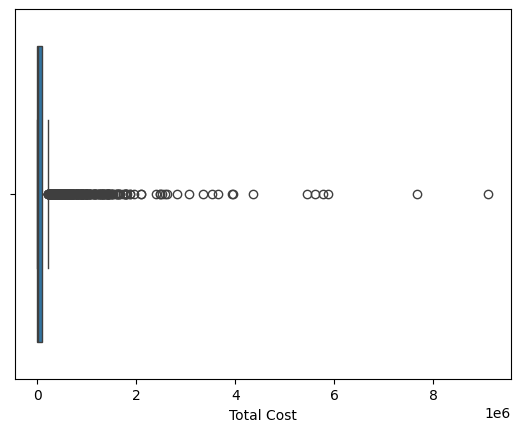

In [29]:
sns.boxplot(x=df_2["Total Cost"])

<Axes: xlabel='Total Weight in lbs'>

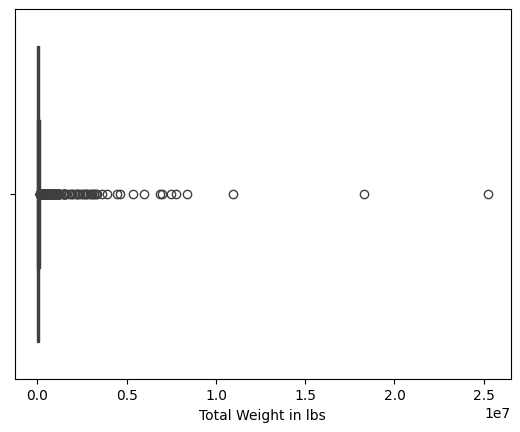

In [30]:
sns.boxplot(x=df_2["Total Weight in lbs"])

<Axes: xlabel='# of Units'>

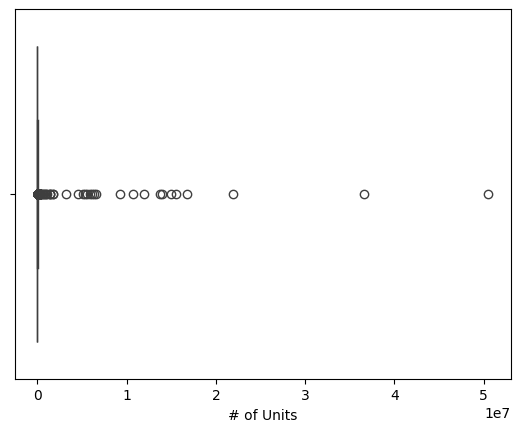

In [31]:
sns.boxplot(x=df_2["# of Units"])

## EDA

#### What is the distribution of Total Cost of the foods?

<Axes: xlabel='Total Cost', ylabel='Count'>

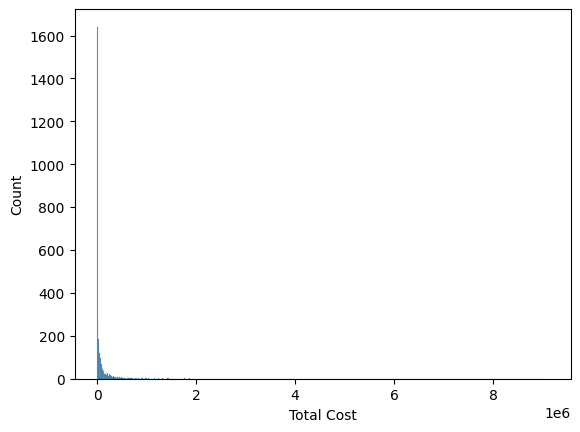

In [32]:
sns.histplot(data=df_2, x="Total Cost")

#### Any strong correlations between features?

<Axes: >

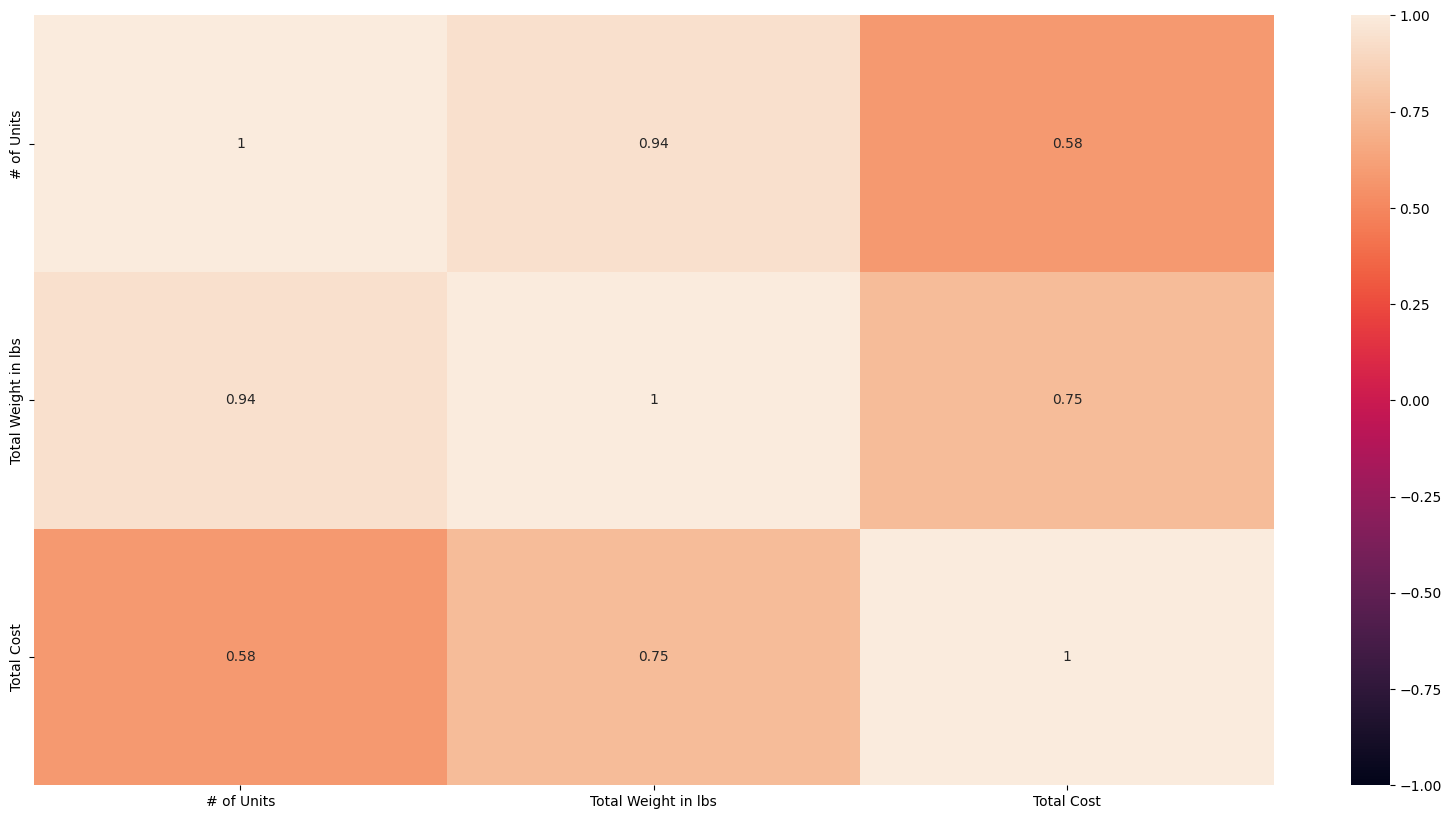

In [33]:
filtered_df = df_2.iloc[:, 9:12]
# correlation matrix
myColors = ("red","white","blue")
cmap1 = clr.LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
corr = filtered_df.corr()
mask = np.zeros_like(corr, dtype=bool)
#mask[np.triu_indices_from(mask)]= True
plt.figure(figsize=(20,10))
sns.heatmap(corr, mask = mask, vmin = -1, vmax = 1, annot=True)

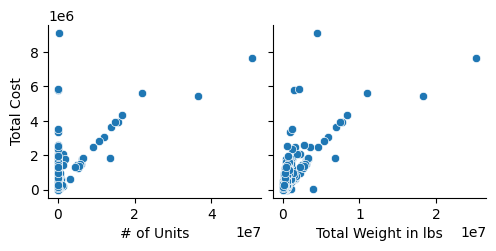

In [41]:
# Let Target be Total_cost
x_vars = ["# of Units", "Total Weight in lbs"]
y_vars = ["Total Cost"]
sns.pairplot(filtered_df, x_vars=x_vars, y_vars=y_vars)

#### How many foods per Food Product Group?

<Axes: xlabel='count', ylabel='Food Product Group'>

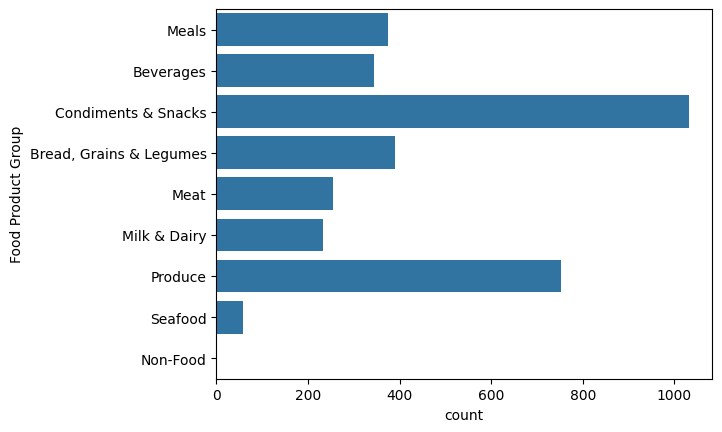

In [42]:
sns.countplot(df_2, y="Food Product Group", orient='h')

#### How many foods per food product category?

<Axes: xlabel='count', ylabel='Food Product Category'>

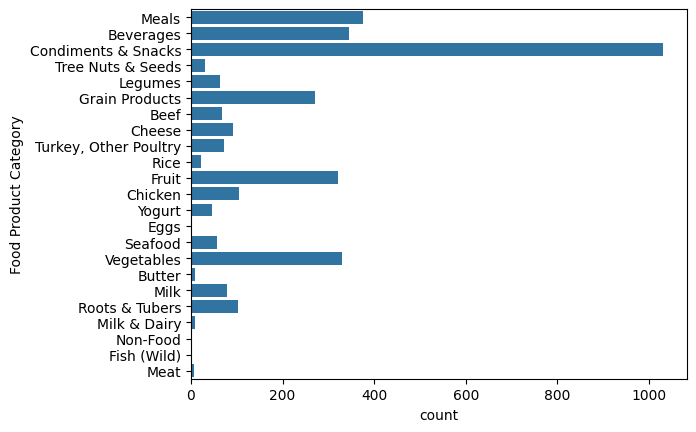

In [43]:
sns.countplot(df_2, y="Food Product Category", orient='h')

## More Boxplots 

<Axes: xlabel='Total Cost', ylabel='Food Product Category'>

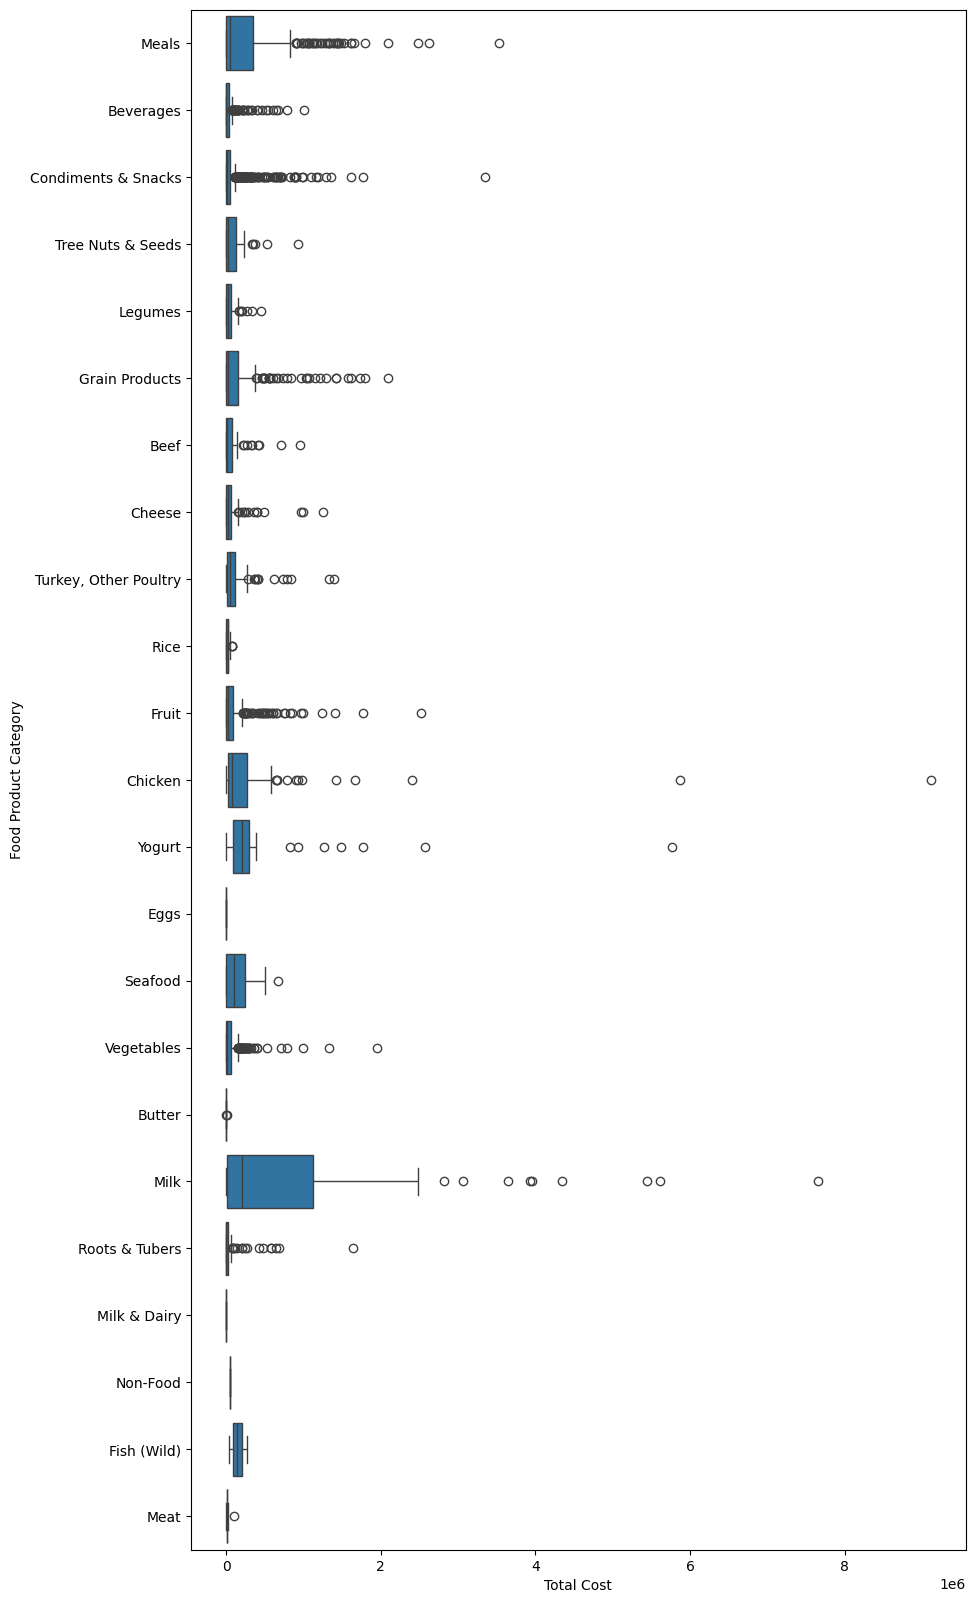

In [44]:
plt.figure(figsize=(10, 20))  # Adjust the figure size as needed
sns.boxplot( x="Total Cost", y="Food Product Category", data=df_2)

<Axes: xlabel='Total Cost', ylabel='Food Product Group'>

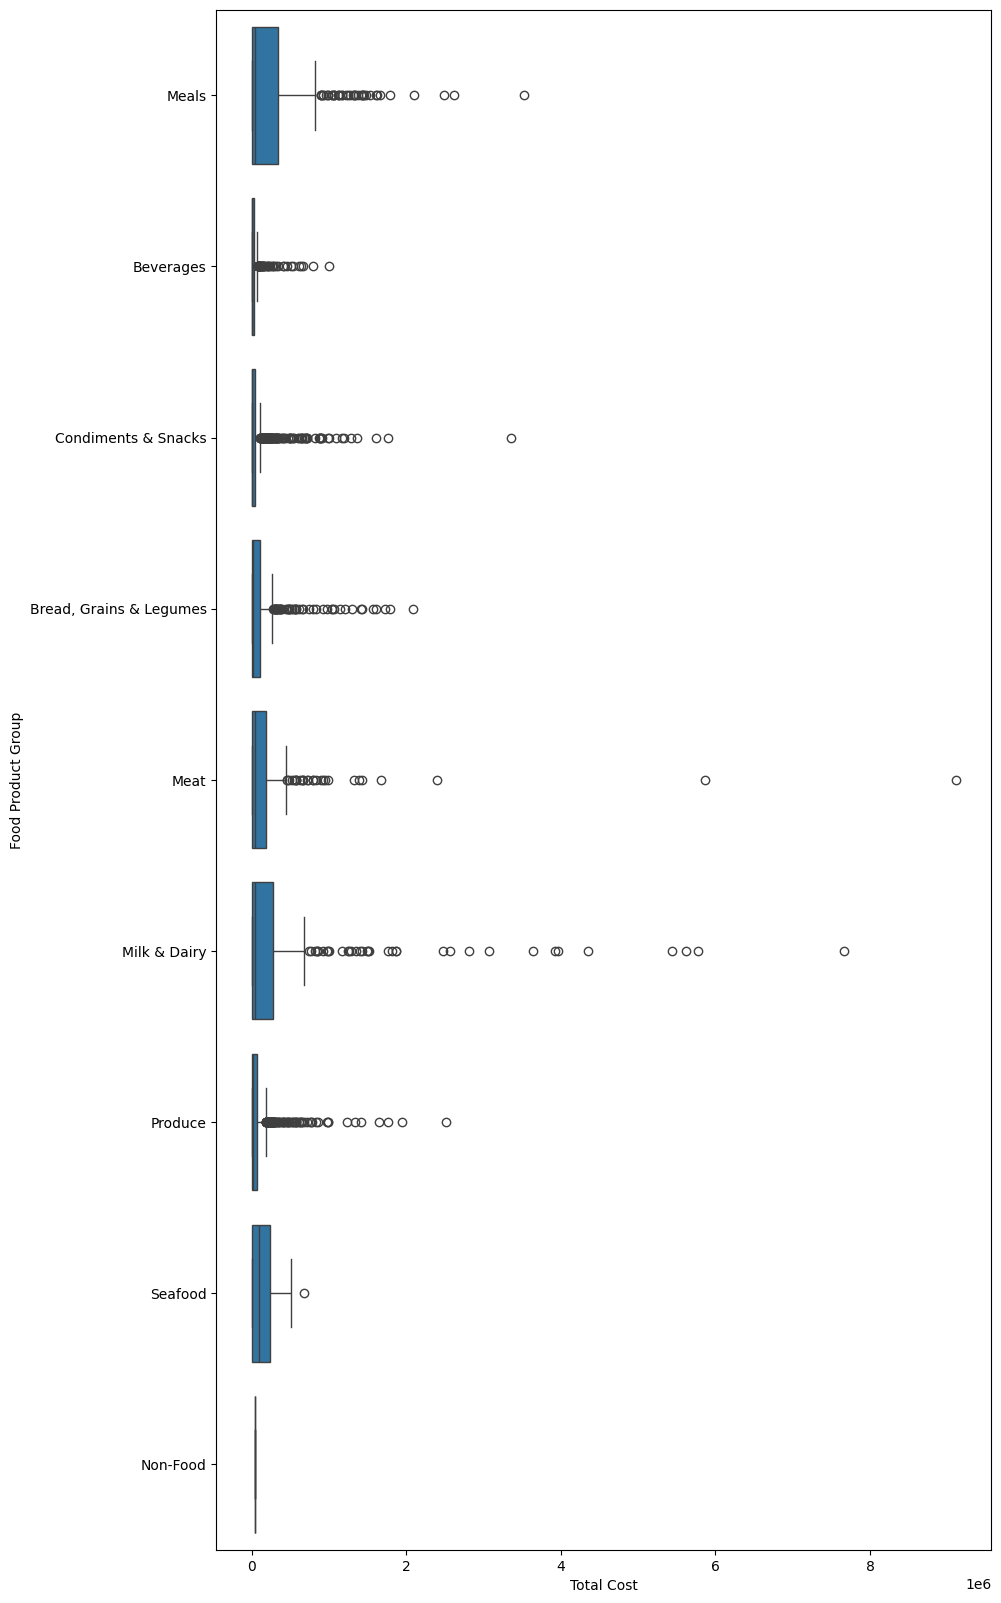

In [45]:
plt.figure(figsize=(10, 20))  # Adjust the figure size as needed
sns.boxplot( x="Total Cost", y="Food Product Group", data=df_2)

<Axes: xlabel='Total Cost', ylabel='Vendor'>

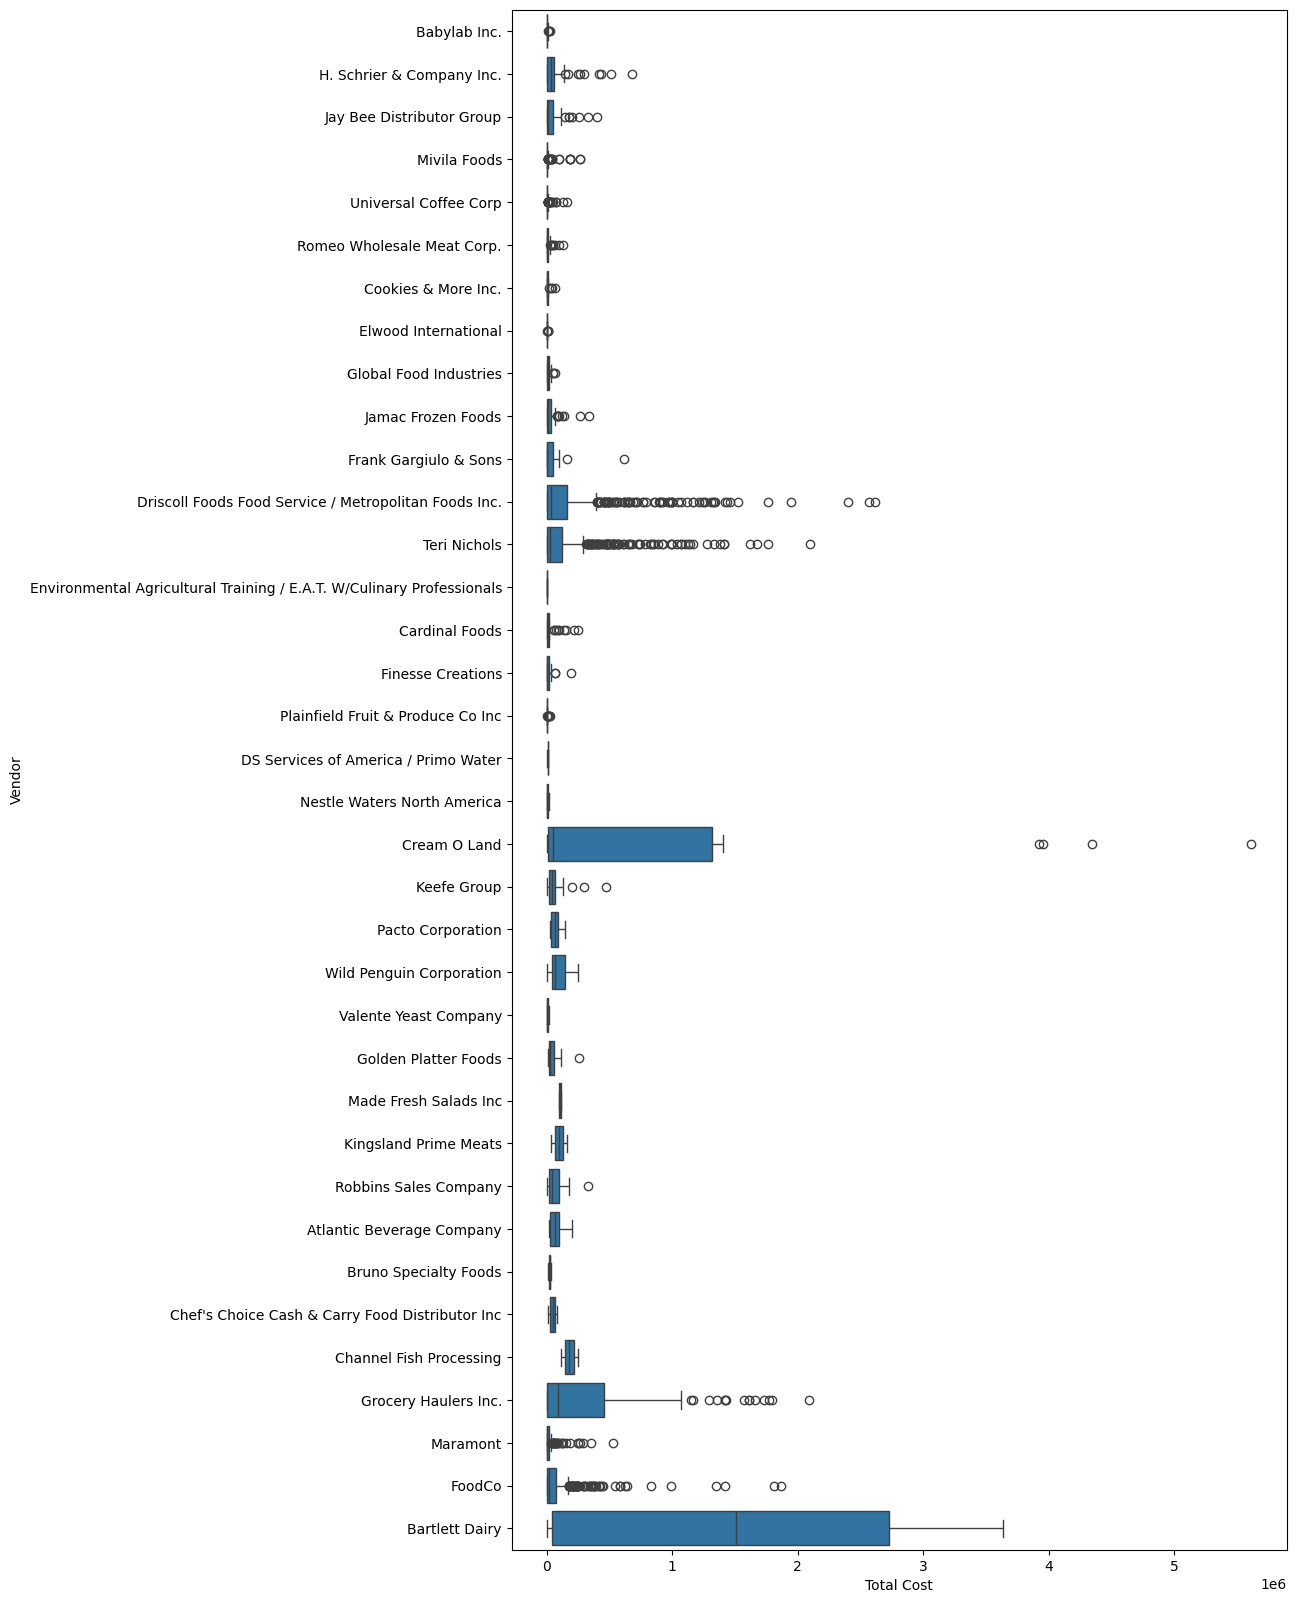

In [46]:
plt.figure(figsize=(10, 20))  # Adjust the figure size as needed
sns.boxplot( x="Total Cost", y="Vendor", data=df_2)

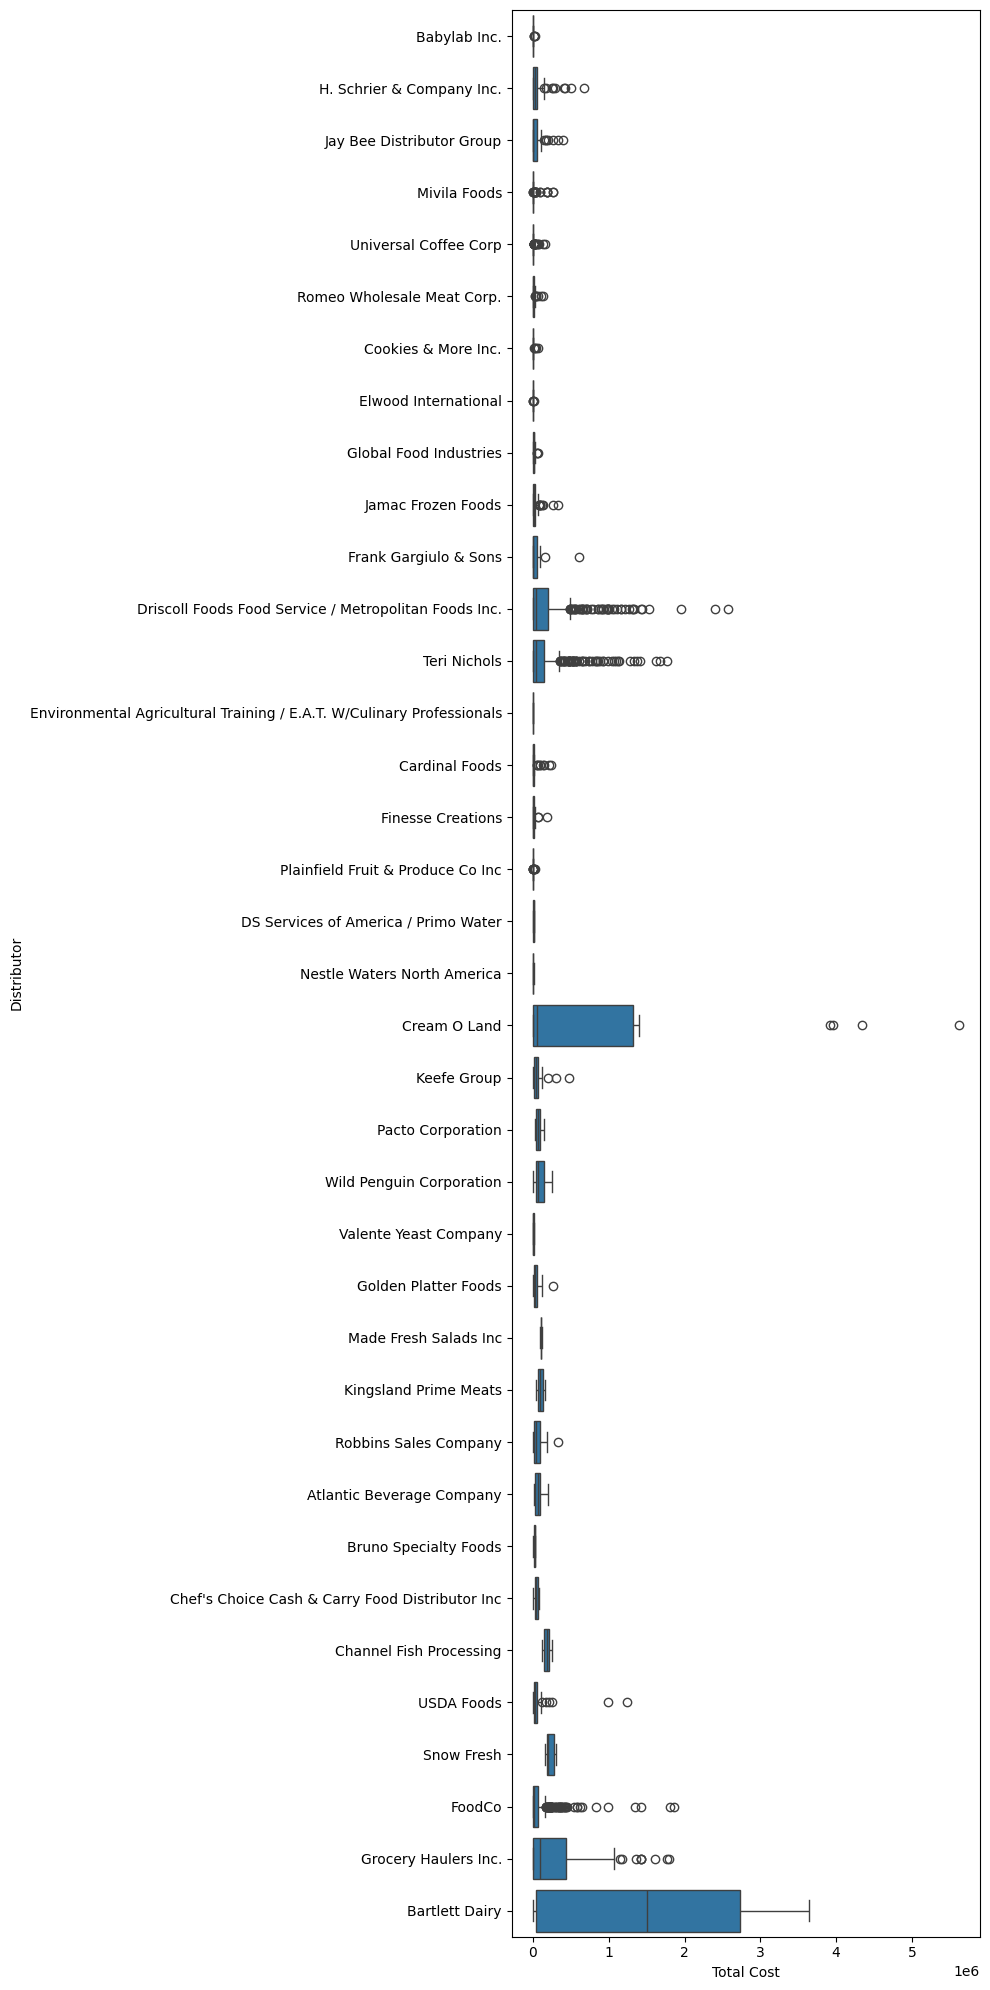

In [47]:
plt.figure(figsize=(10, 20))  # Adjust the figure size as needed
sns.boxplot( x="Total Cost", y="Distributor", data=df_2)
plt.tight_layout()  # Adjust layout for better visibility

#### Show top 5 highest priced products from top 5 vendors

<Axes: title={'center': 'Top Distributors'}, xlabel='Distributor'>

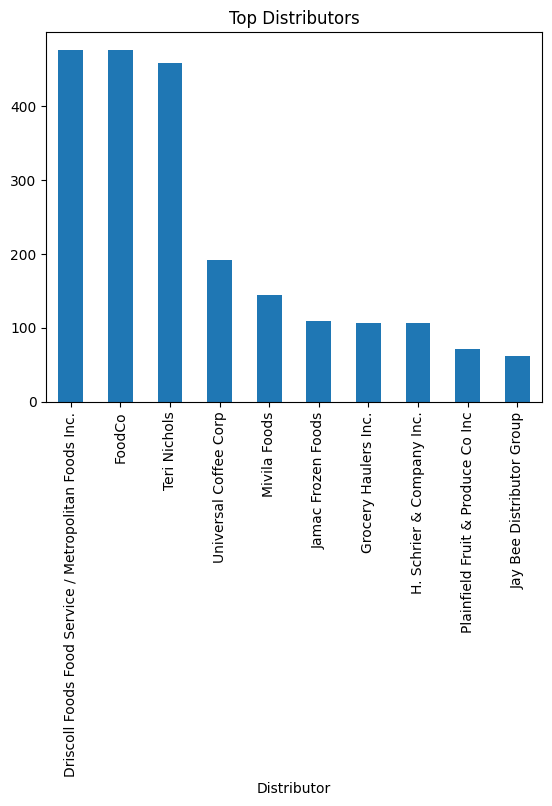

In [48]:
df_2["Distributor"].value_counts() \
.head(10) \
.plot(kind="bar", title="Top Distributors")

#### Top Distributors whose food products cost more than 1000 USD

<Axes: title={'center': 'Top Distributors whose food products cost more than 1000 USD'}, xlabel='Distributor'>

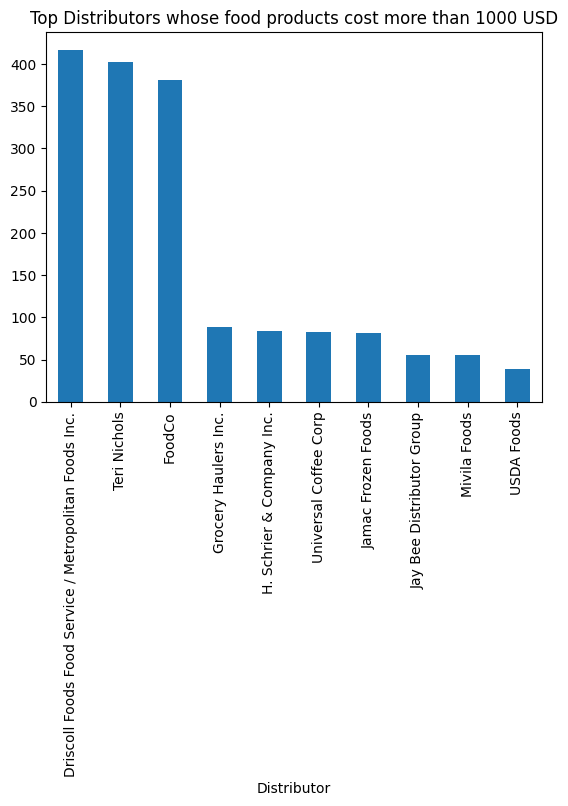

In [54]:
df_2.query("`Total Cost` > 1000")["Distributor"].value_counts() \
.head(10) \
.plot(kind="bar", title="Top Distributors whose food products cost more than 1000 USD")

## Scaling & Encoding
- Scale: '# of Units', 'Total Weight in lbs', 'Total Cost'
- Encode: 'Food Product Category', 'Food Product Group'

In [34]:
df_2.describe()

,# of Units,Total Weight in lbs,Total Cost
count,3.441000e+03,3.428000e+03,3.442000e+03
mean,8.749927e+04,1.235444e+05,1.341548e+05
std,1.332750e+06,7.083248e+05,4.223606e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+02,7.237500e+02,1.144750e+03
50%,8.790000e+02,9.169000e+03,1.436600e+04
75%,4.968000e+03,6.730325e+04,8.852700e+04
max,5.050947e+07,2.525474e+07,9.110741e+06


In [35]:
# filter out some columns
df = df_2[[# 'Agency', 'Time Period', 
    #    'Product Name', 'Product Type', 'Origin Detail', 'Distributor',
    #    'Vendor', 
    #    'Food Product Category',
         'Vendor',  'Food Product Group', '# of Units', 'Total Weight in lbs', 'Total Cost']].copy()

In [36]:
# Define numeric and categorical features
numeric_features = ['# of Units', 'Total Weight in lbs']
categorical_features = ['Vendor', 'Food Product Group']

# Create transformers
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

xgb_model = XGBRegressor()

model = Pipeline(steps=[("preprocessor", preprocessor), ("model", xgb_model)])

#### exhaustively search for the optimal hyperparameters

In [37]:
# Split data into features and target
X = df.drop('Total Cost', axis=1)
y = df['Total Cost']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
# set up our search grid
param_grid = {"model__max_depth":    [4, 5, 6],
              "model__n_estimators": [500, 600, 700],
              "model__learning_rate": [0.01, 0.015]}

# try out every combination of the above values
search = GridSearchCV(model, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)
print("The best score is ",search.best_score_)

The best hyperparameters are  {'model__learning_rate': 0.015, 'model__max_depth': 4, 'model__n_estimators': 700}
The best score is  0.7915024092434398


In [61]:
search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['# '
                                                                          'of '
                                                                          'Units',
                                                                          'Total '
                                                                          'Weight '
                                                                          'in '
                                                                          'lbs']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Vendor',
                                                                          'Food '
                                                                          'Product '
                                                                          'Group'])])),
                                       ('model',
                                        XGBRegressor(base_score=None,
                                                     booster=Non...
                                                     max_cat_threshold=None,
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             param_grid={'model__learning_rate': [0.01, 0.015],
                         'model__max_depth': [4, 5, 6],
                         'model__n_estimators': [500, 600, 700]})

## Evaluate model


In [39]:
# Calculate MAE
y_pred = search.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', mae)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('Root Mean Squared Error:', rmse)

Mean Absolute Error: 57229.32041287249
Mean Squared Error: 81972006786.9568
Root Mean Squared Error: 286307.53882312775


c:\Users\rahul\OneDrive\Documents\Desktop\food_cost_prediction\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [40]:
pd.DataFrame({'Actual': y_test[:5], 'Prediction': search.predict(X_test)[:5]})

,Actual,Prediction
4783,5136.0,12219.028320
51,157.0,3161.960205
14515,31703.0,84820.210938
568,2506.0,3096.875732
15278,320.0,12219.028320
